In [1]:
from typing import Tuple

import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
from aesara import shared as tshared
import aesara.tensor as tt
from aesara import function, printing
import arviz as az

# Random seed
RANDOM_SEED = 713
np.random.seed(713)

In [2]:
import matplotlib

%matplotlib inline

matplotlib.rcParams.update(
    {"font.size": 16, "axes.labelsize": 24, "axes.titlesize": 18, "text.usetex": True,
    "xtick.major.width": 1.5, "xtick.minor.width": 1.2, "ytick.major.width": 1.5, "ytick.minor.width": 1.2,
    "legend.fontsize": 18}
)

matplotlib.rcParams['figure.dpi']= 150

# colors to use
c_flatirons = '#8B2131'
c_sunshine = '#CA9500'
c_skyline = '#1D428A'
c_midnight = '#0E2240'

colors = [c_flatirons, c_sunshine, c_skyline, c_midnight]

## Infer dGMGP Emulation errors as a function of both L1 and L2


In [3]:
# (LF points, HF points, mean errors, stds)
data = np.loadtxt("../budget_size/dgmgp_bugdget_all_z.txt")

The parametric model is

$$
\mathrm{error} = \theta \cdot n_\mathrm{LF}^{- \nu / d} + n_\mathrm{HF}^{- \nu / d}
$$

In [4]:
x_train = data[:, [0, 1]] # (HF, LF) pairs
y_train = data[:, [2]]    # predicted error
y_sigma = data[:, [3]]    # predicted errors' sigma (std over test examples)

# dimensionality of the emulator
d = 5

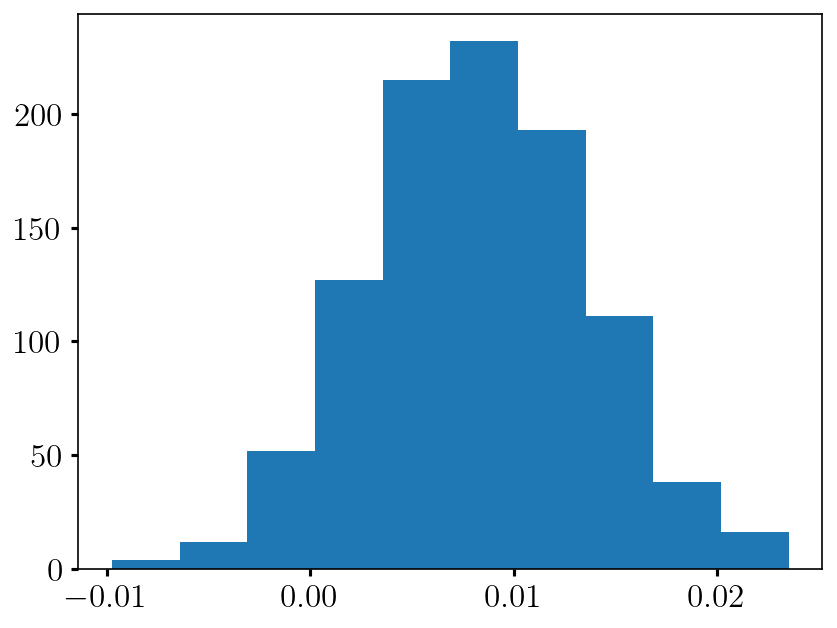

In [5]:
plt.hist(pm.Normal.dist(mu=y_train.mean(), sigma=y_train.std(), size=1000).eval());

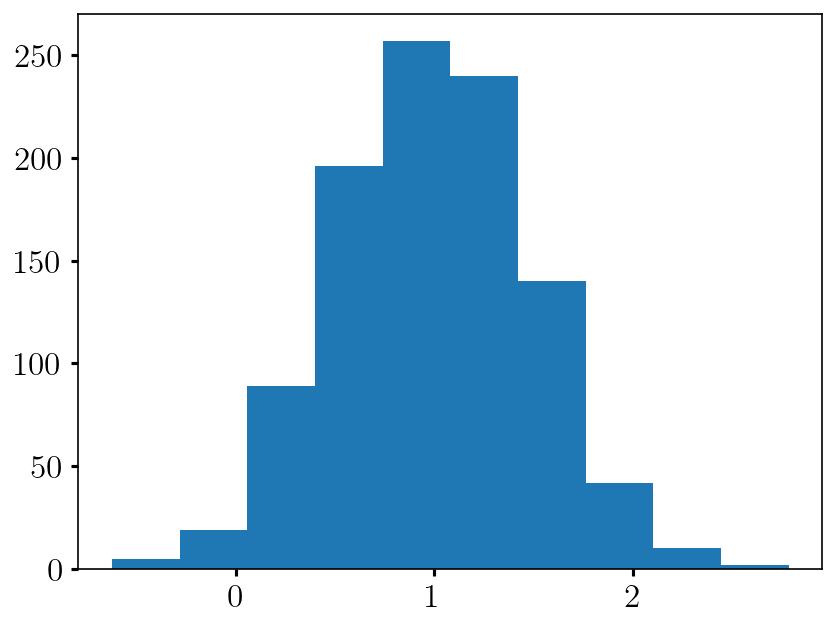

In [6]:
# sbird: highly informed prior for rho
plt.hist(pm.Normal.dist(mu=1, sigma=0.5, size=1000).eval());

## Prior for rho

Perhaps a better way is to get the prior values of rho from the trained GPs.

To test:
1. multiple redshifts
2. How this will benefit other people's emulators?
3. Extend to GMGP

## Inference for dGMGP all redshifts

In [7]:
with pm.Model() as budget_model:
    # Mean emulation error
    theta = pm.Normal("theta", mu=y_train.mean(), sigma=y_train.std())
    # theta = pm.LogNormal("theta", mu=np.log(y_train.mean()), sigma=0.5)

    # Correlation parameter
    # rho   = pm.Uniform("rho", 0, 50)
    # rho1   = pm.LogNormal("rho1", 0, 0.5)
    # rho2   = pm.LogNormal("rho2", 0, 0.5)
    rho1   = pm.Normal("rho1", 1, 1)
    rho2   = pm.Normal("rho2", 1, 1)

    # Observational noise
    # sigma = pm.LogNormal("obs_noise", 0, 1)

    # Spectral index for the power-law relation
    nu1 = pm.LogNormal("nu1", 0, 1)
    nu2 = pm.LogNormal("nu2", 0, 1)
    nu0 = pm.LogNormal("nu0", 0, 1)

    y = theta * (
        rho1 * x_train[:, 1] ** (- nu1 / d) + 
        rho2 * x_train[:, 1] ** (- nu2 / d) +
        x_train[:, 0] ** (- nu0 / d)
    )

    pm.Normal(
        "likelihood",
        mu=y,
        sigma=y_sigma[:, 0],
        observed=y_train[:, 0]
    )

In [8]:
with budget_model:
    start = {
        "theta" : y_train.mean(),
        "rho1"  : 1,
        "rho2"  : 1,
        "nu1" : 6,
        "nu2" : 6,
        "nu0" : 6,
    }

    trace = pm.sample(10000, tune=35000, initvals=start, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, rho1, rho2, nu1, nu2, nu0]


Sampling 4 chains for 35_000 tune and 10_000 draw iterations (140_000 + 40_000 draws total) took 163 seconds.


In [9]:
# Normal("rho", 1, 0.5): likelihood: 3.93283288
# LogNormal("rho", 0, 0.5): likelihood: 3.9477437
# Normal("rho", 1, 1): likelihood: 3.94582063
# LogNormal("rho", 0, 1): likelihood: 3.96781832

# theta = pm.LogNormal("theta", mu=y_train.mean(), sigma=y_train.std() * 2): likelihood: 3.97154675
trace.log_likelihood.likelihood.median()

<xarray.DataArray 'likelihood' ()>
array(5.5042715)

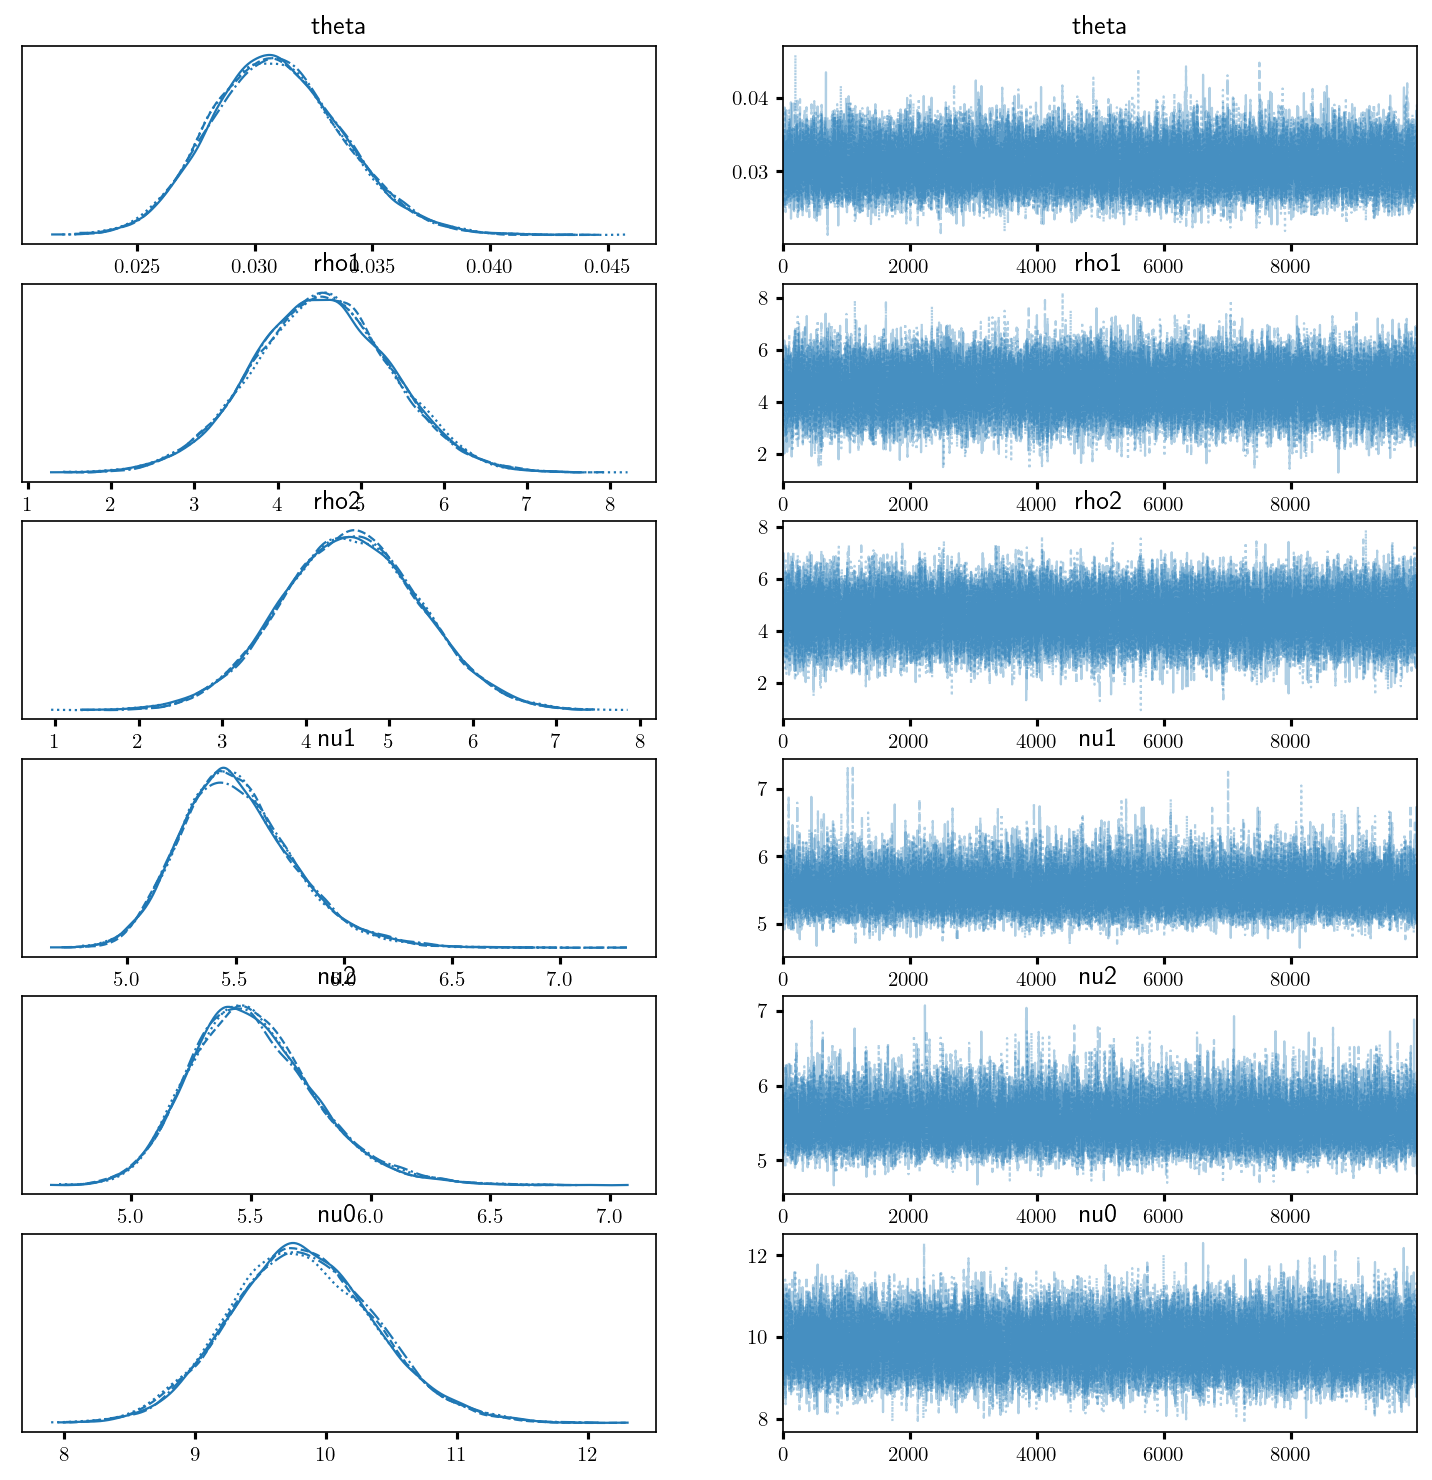

In [10]:
# plotting setting to make the arviz plots look less buggy
# az.style.use("arviz-darkgrid")

with budget_model:
    rvs = [
        "theta",
        "rho1",
        "rho2",
        "nu1",
        "nu2",
        "nu0",
        # "obs_noise"
    ]

    _ = az.plot_trace(trace, var_names=rvs)
    
# plt.savefig("/home/jibancat/Documents/Latex/mf_boxsize_paper/images/budget_mcmc_chains.pdf", bbox_inches='tight', pad_inches=0.075)


## Posterior preditions

In [11]:
# shared parameters
n_hf = x_train[:, 0]
n_lf = x_train[:, 1]
y_true = y_train[:, 0]

In [12]:
def get_quantiles(trace) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    # Finding the quantiles
    theta_lower, theta_median, theta_upper = np.quantile(trace.posterior["theta"], [0.25, 0.5, 0.75])
    rho1_lower, rho1_median, rho1_upper    = np.quantile(trace.posterior["rho1"], [0.25, 0.5, 0.75])
    rho2_lower, rho2_median, rho2_upper    = np.quantile(trace.posterior["rho2"], [0.25, 0.5, 0.75])
    nu1_lower, nu1_median, nu1_upper       = np.quantile(trace.posterior["nu1"], [0.25, 0.5, 0.75])
    nu2_lower, nu2_median, nu2_upper       = np.quantile(trace.posterior["nu2"], [0.25, 0.5, 0.75])
    nu0_lower, nu0_median, nu0_upper       = np.quantile(trace.posterior["nu0"], [0.25, 0.5, 0.75])

    return (
        rho1_median, rho2_median, theta_median, nu1_median, nu2_median, nu0_median,
        rho1_upper,  rho2_upper,  theta_upper,  nu1_upper,  nu2_upper,  nu0_upper,
        rho1_lower,  rho2_lower,  theta_lower,  nu1_lower,  nu2_lower,  nu0_lower,
    )

def budget_size_fn(num_lf, num_hf, theta, rho1, rho2, nu1, nu2, nu0, d=5):
    return theta * (
        rho1 * num_lf ** (- nu1 / d) +
        rho2 * num_lf ** (- nu2 / d) +
        num_hf ** (- nu0 / d)
    )

def budget_size_fn_l1_l2(num_l1, num_l2, num_hf, theta, rho1, rho2, nu1, nu2, nu0, d=5):
    """This is to include both L1 and L2 numbers"""
    return theta * (
        rho1 * num_l1 ** (- nu1 / d) +
        rho2 * num_l2 ** (- nu2 / d) +
        num_hf ** (- nu0 / d)
    )    

In [13]:
(
    rho1_median, rho2_median, theta_median, nu1_median, nu2_median, nu0_median,
    rho1_upper,  rho2_upper,  theta_upper,  nu1_upper,  nu2_upper,  nu0_upper,
    rho1_lower,  rho2_lower,  theta_lower,  nu1_lower,  nu2_lower,  nu0_lower,
) = get_quantiles(trace)

In [14]:
y_pred       = budget_size_fn(n_lf, n_hf, theta_median, rho1_median, rho2_median, nu1_median, nu2_median, nu0_median, d=5)

# nu has to be lower for upper bounds of y_pred
y_pred_lower = budget_size_fn(n_lf, n_hf, theta_lower,  rho1_lower,  rho2_lower,  nu1_upper,  nu2_upper,  nu0_upper,  d=5)
y_pred_upper = budget_size_fn(n_lf, n_hf, theta_upper,  rho1_upper,  rho2_upper,  nu1_lower,  nu2_lower,  nu0_lower,  d=5)

In [23]:
print("Theta:", (theta_median, theta_lower, theta_upper))
print("Rho1:", (rho1_median, rho1_lower, rho1_upper))
print("Rho2:", (rho2_median, rho2_lower, rho2_upper))
print("nu1:", (nu1_median, nu1_lower, nu1_upper))
print("nu2:", (nu2_median, nu2_lower, nu2_upper))
print("nu0:", (nu0_median, nu0_lower, nu0_upper))

Theta: (0.030825619526999616, 0.02899043097019025, 0.03274566453945431)
Rho1: (4.529013995934827, 3.965322256482266, 5.084555183213879)
Rho2: (4.535517540794691, 3.9707026329296133, 5.099309775197762)
nu1: (5.487294203478671, 5.326658235807338, 5.671032617726837)
nu2: (5.4877441766805815, 5.327176133742258, 5.671319988425586)
nu0: (9.80022679590536, 9.437381575662046, 10.18438208971487)


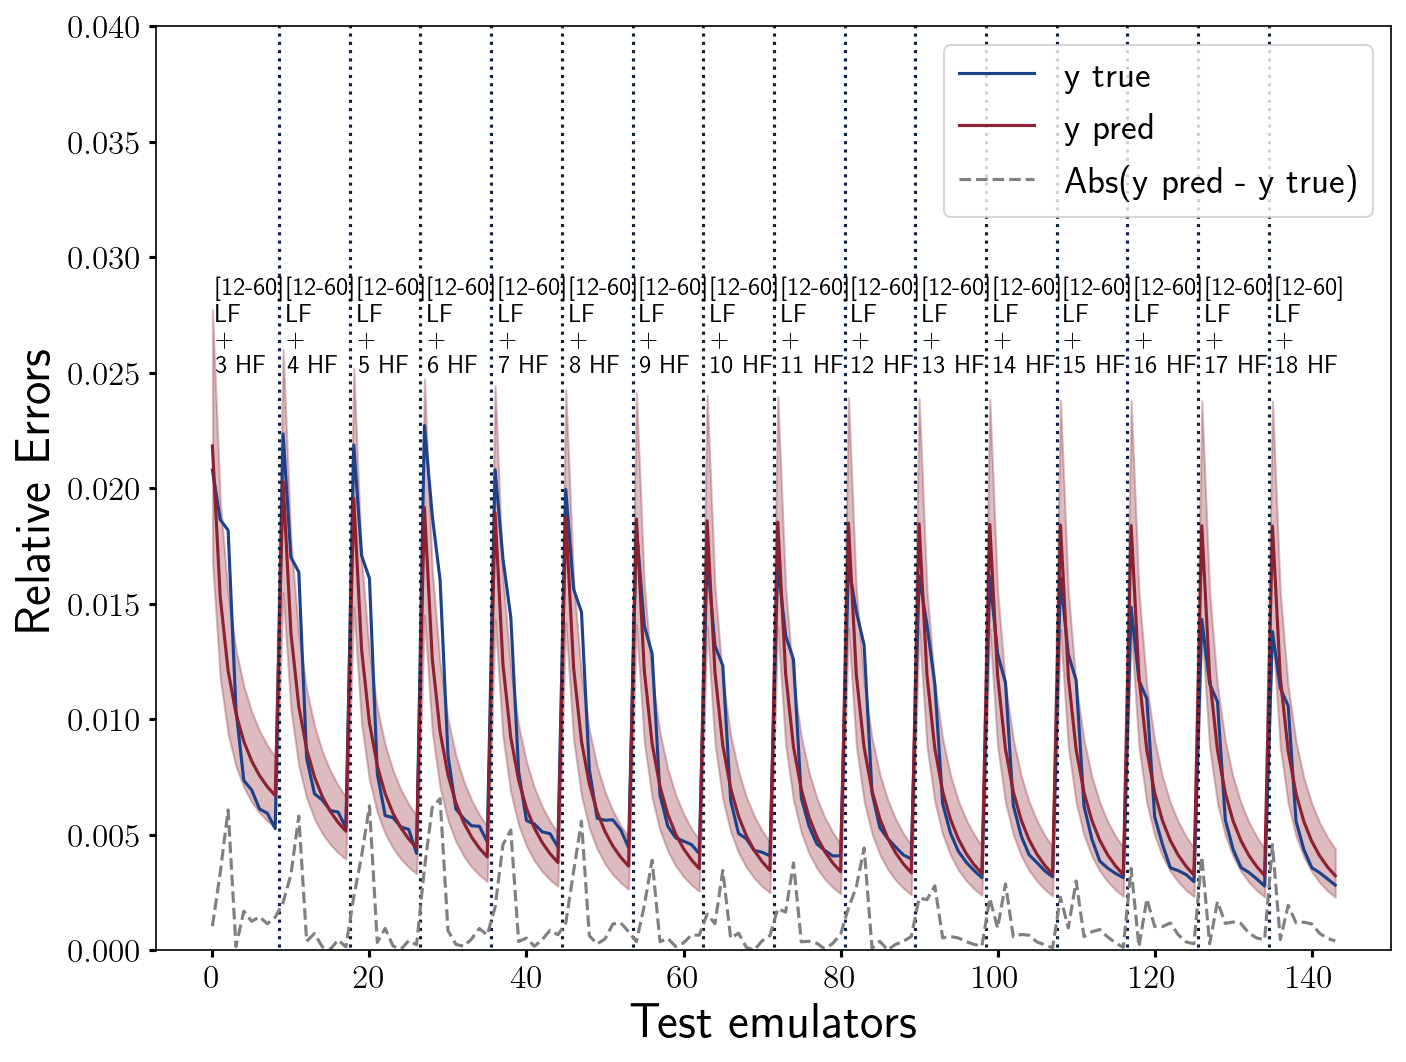

In [16]:
fig, ax = plt.subplots(figsize=(10.625, 8), nrows=1, ncols=1)

plt.plot(range(len(y_true)), y_true, label=r"y true", color=colors[2])
plt.plot(range(len(y_true)), y_pred, label=r"y pred", color=colors[0])

hf_size = len(set(n_hf))
lf_size = len(set(n_lf))

plt.vlines(
    [
        lf_size - 0.5 + lf_size * i for i in range(hf_size - 1)
    ],
    ymin=-0.01, ymax=0.07, ls="dotted", color=colors[3])

for i in range(hf_size):
    plt.text(
        0.5 + lf_size * i,
        0.025,
        "[12-60]\nLF\n+\n{} HF".format(3 + i),
        fontdict={"fontsize" : 12}
    )


plt.fill_between(range(len(y_true)), y1=y_pred_lower, y2=y_pred_upper, alpha=0.3, color=colors[0])

plt.plot(np.abs(y_pred - y_true), ls="--", color="grey", label=r"Abs(y pred - y true)" )

plt.ylim((0.0, 0.04))
plt.ylabel("Relative Errors")
plt.xlabel("Test emulators")
plt.legend()

fig.savefig("../../../Latex/mf_boxsize_paper/images/budget_all_test_errors_dgmgp.pdf", bbox_inches='tight', pad_inches=0.075)


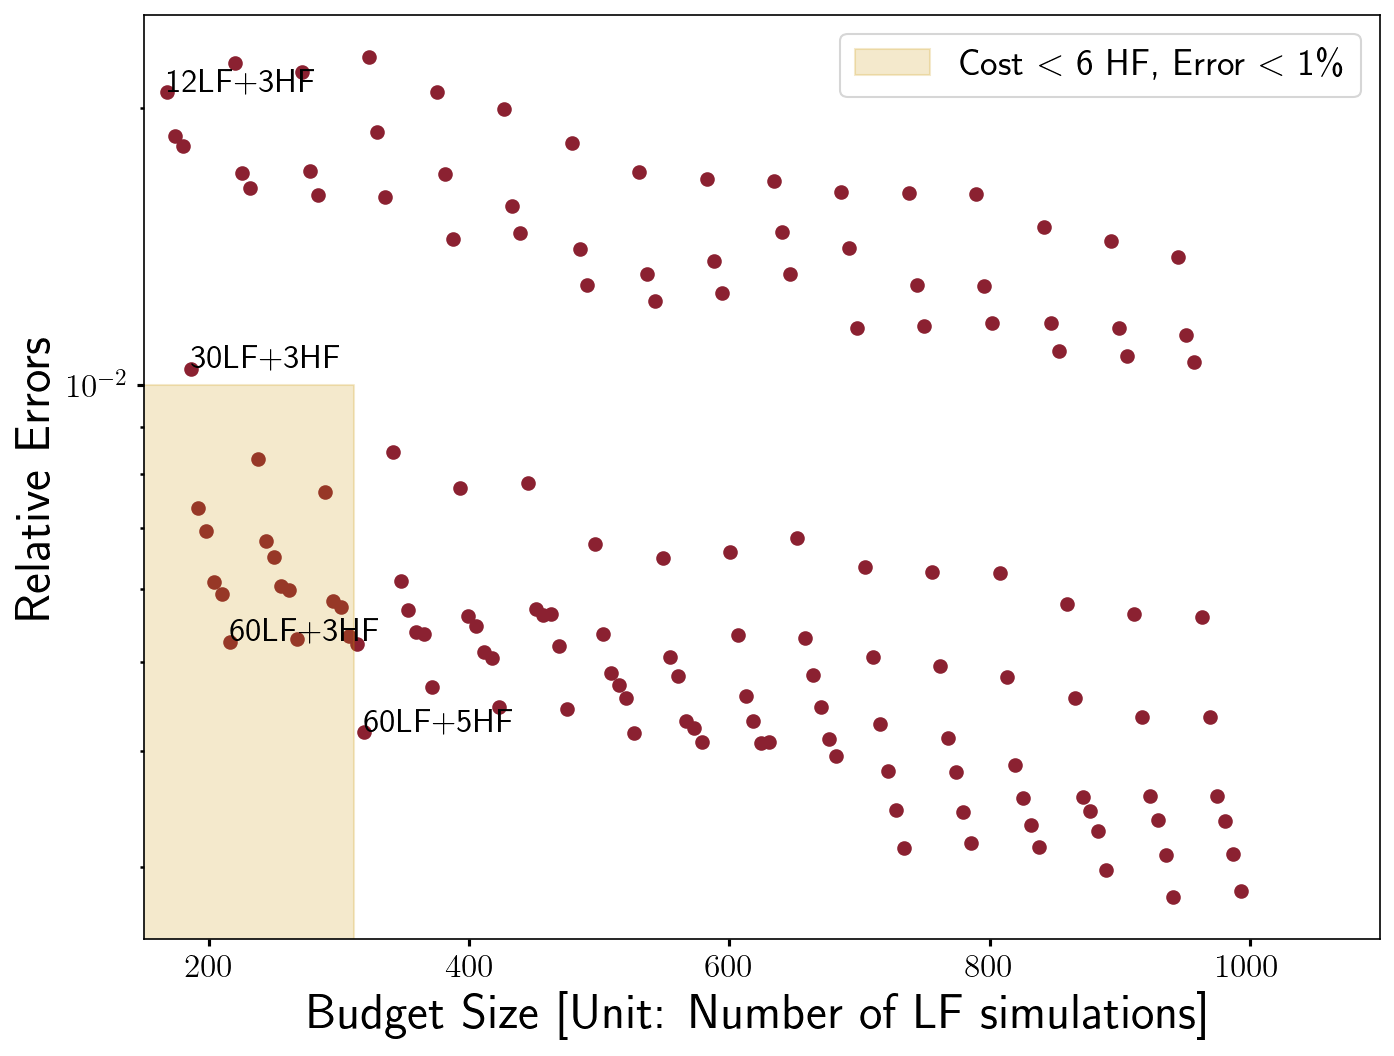

In [16]:
fig, ax = plt.subplots(figsize=(10.625, 8), nrows=1, ncols=1)

cost = 140 / (1 + 1.7)

ax.scatter(
    n_lf + n_hf * cost, y_true,
    color=colors[0]
)
ax.set_yscale("log")

ax.fill_between(
    np.linspace(0, 6 * cost), y1=0.01, alpha=0.2, color=colors[1],
    label="Cost $<$ 6 HF, Error $<$ 1\%"
)

for i,(x,y) in enumerate(zip(n_lf + n_hf * cost, y_true)):
    # if i < 40:
    #     plt.text(x, y, i)    
    if i in [0, 3, 8, 26]:
        plt.text(x, y, "{}LF+{}HF".format(int(n_lf[i]), int(n_hf[i])))

ax.set_xlim(150, 1100)
ax.legend()

plt.xlabel("Budget Size [Unit: Number of LF simulations]")
plt.ylabel("Relative Errors")

fig.savefig("../../../Latex/mf_boxsize_paper/images/budget_all_costs_errors_dgmgp.pdf", bbox_inches='tight', pad_inches=0.075)

## Posterior extrapolation beyond the fitting range

In [17]:
def plot_lf_fn(
        lf_min: int, lf_max: int, selected_hf: int,
        rho1_median, rho2_median, theta_median, nu1_median, nu2_median, nu0_median,
        rho1_upper,  rho2_upper,  theta_upper,  nu1_upper,  nu2_upper,  nu0_upper,
        rho1_lower,  rho2_lower,  theta_lower,  nu1_lower,  nu2_lower,  nu0_lower,
        color,
        ):
    """
    Plot the error(n_lf) and overplot true errors(n_hf == selected_hf)
    """
    all_n_lfs = np.arange(lf_min, lf_max)

    ind = x_train[:, 0] == selected_hf
    data_lf    = x_train[ind, 1]
    data_error = y_train[ind, 0]

    # Predictions
    plt.plot(
        all_n_lfs,
        budget_size_fn(all_n_lfs, selected_hf, theta_median, rho1_median, rho2_median, nu1_median, nu2_median, nu0_median),
        label="Estimated: {} HF".format(selected_hf),
        color=color
    )
    plt.fill_between(
        all_n_lfs,
        y1=budget_size_fn(all_n_lfs, selected_hf, theta_lower,  rho1_lower,  rho2_lower,  nu1_upper,  nu2_upper,  nu0_upper),
        y2=budget_size_fn(all_n_lfs, selected_hf, theta_upper,  rho1_upper,  rho2_upper,  nu1_lower,  nu2_lower,  nu0_lower),
        color=color,
        alpha=0.25
    )
    # Ture values
    plt.plot(data_lf, data_error, label="data: {}HF".format(selected_hf), ls="--", marker="o", color=color)

def plot_hf_fn(
        hf_min: int, hf_max: int, selected_lf: int,
        rho1_median, rho2_median, theta_median, nu1_median, nu2_median, nu0_median,
        rho1_upper,  rho2_upper,  theta_upper,  nu1_upper,  nu2_upper,  nu0_upper,
        rho1_lower,  rho2_lower,  theta_lower,  nu1_lower,  nu2_lower,  nu0_lower,
        color,
        ):
    """
    Plot the error(n_hf) and overplot true errors(n_lf == selected_lf)
    """
    all_n_hfs = np.arange(hf_min, hf_max)

    ind = x_train[:, 1] == selected_lf
    data_hf    = x_train[ind, 0]
    data_error = y_train[ind, 0]

    # Predictions
    plt.plot(
        all_n_hfs,
        budget_size_fn(selected_lf, all_n_hfs, theta_median, rho1_median, rho2_median, nu1_median, nu2_median, nu0_median),
        label="Estimated: {} LF".format(selected_lf),
        color=color
    )
    plt.fill_between(
        all_n_hfs,
        y1=budget_size_fn(selected_lf, all_n_hfs, theta_lower,  rho1_lower,  rho2_lower,  nu1_upper,  nu2_upper,  nu0_upper),
        y2=budget_size_fn(selected_lf, all_n_hfs, theta_upper,  rho1_upper,  rho2_upper,  nu1_lower,  nu2_lower,  nu0_lower),
        color=color,
        alpha=0.25
    )
    # Ture values
    plt.plot(data_hf, data_error, label="data: {}LF".format(selected_lf), ls="--", marker="o", color=color)


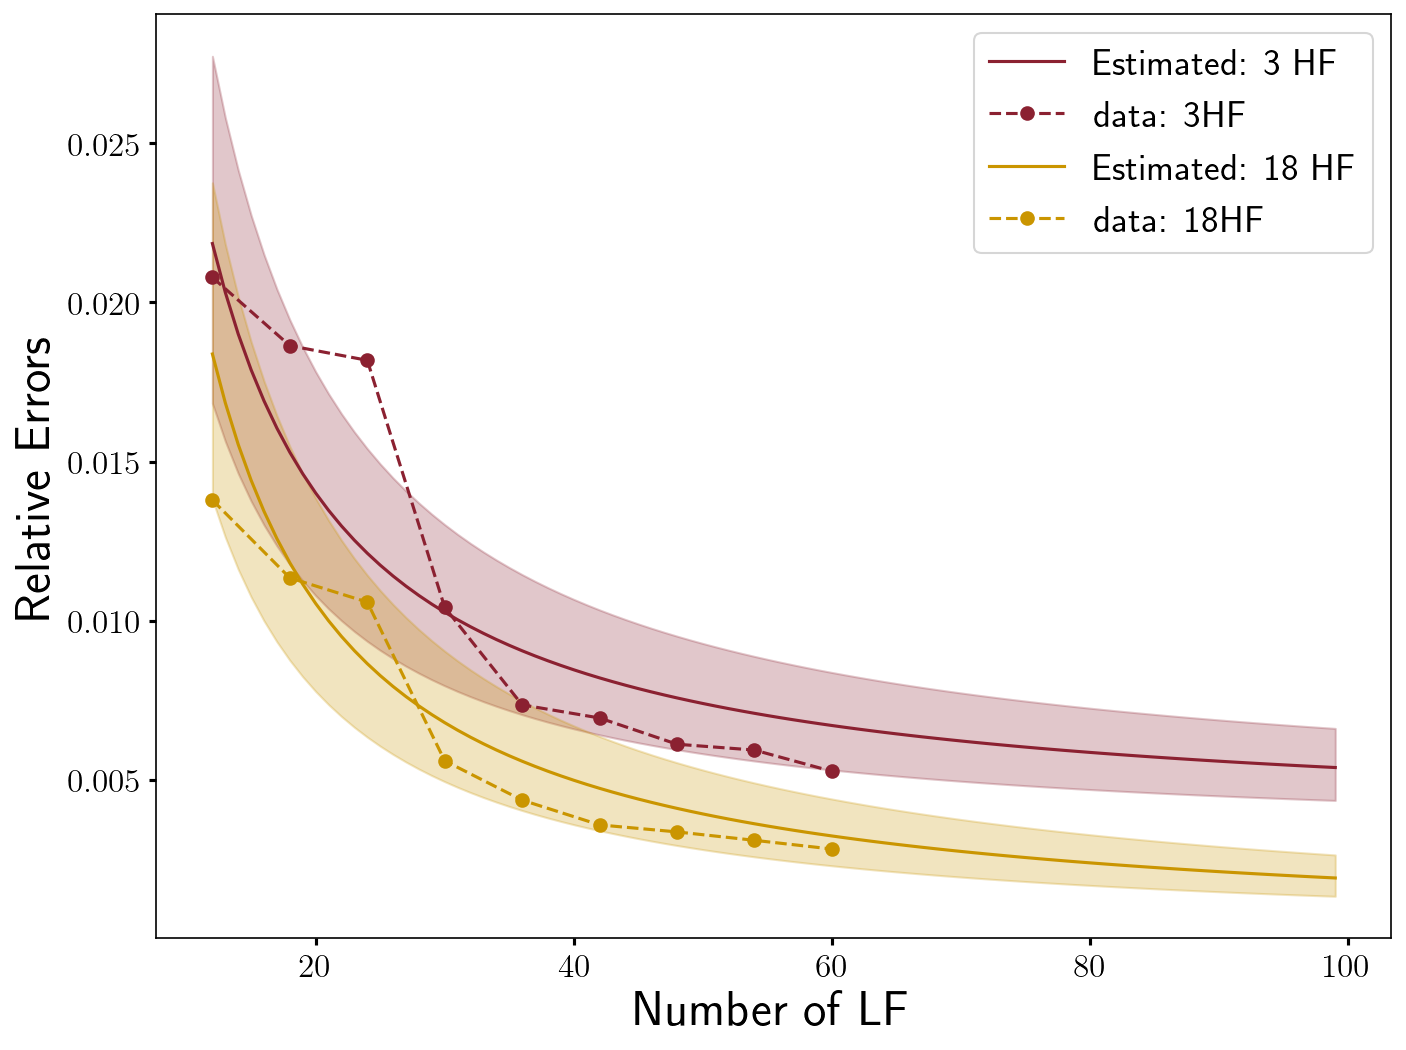

In [18]:
fig, ax = plt.subplots(figsize=(10.625, 8), nrows=1, ncols=1)

plot_lf_fn(
    lf_min=12,
    lf_max=100,
    selected_hf=3,
    rho1_median=rho1_median,
    rho2_median=rho2_median,
    theta_median=theta_median,
    nu1_median=nu1_median,
    nu2_median=nu2_median,
    nu0_median=nu0_median,
    rho1_upper=rho1_upper,
    rho2_upper=rho2_upper,
    theta_upper=theta_upper,
    nu1_upper=nu1_upper,
    nu2_upper=nu2_upper,
    nu0_upper=nu0_upper,
    rho1_lower=rho1_lower,
    rho2_lower=rho2_lower,
    theta_lower=theta_lower,
    nu1_lower=nu1_lower,
    nu2_lower=nu2_lower,
    nu0_lower=nu0_lower,
    color=colors[0]
)


plot_lf_fn(
    lf_min=12,
    lf_max=100,
    selected_hf=18,
    rho1_median=rho1_median,
    rho2_median=rho2_median,
    theta_median=theta_median,
    nu1_median=nu1_median,
    nu2_median=nu2_median,
    nu0_median=nu0_median,
    rho1_upper=rho1_upper,
    rho2_upper=rho2_upper,
    theta_upper=theta_upper,
    nu1_upper=nu1_upper,
    nu2_upper=nu2_upper,
    nu0_upper=nu0_upper,
    rho1_lower=rho1_lower,
    rho2_lower=rho2_lower,
    theta_lower=theta_lower,
    nu1_lower=nu1_lower,
    nu2_lower=nu2_lower,
    nu0_lower=nu0_lower,
    color=colors[1]
)

plt.xlabel("Number of LF")
plt.ylabel("Relative Errors")
plt.legend()
fig.savefig("../../../Latex/mf_boxsize_paper/images/budget_inferred_LR_error_dgmgp.pdf", bbox_inches='tight', pad_inches=0.075)

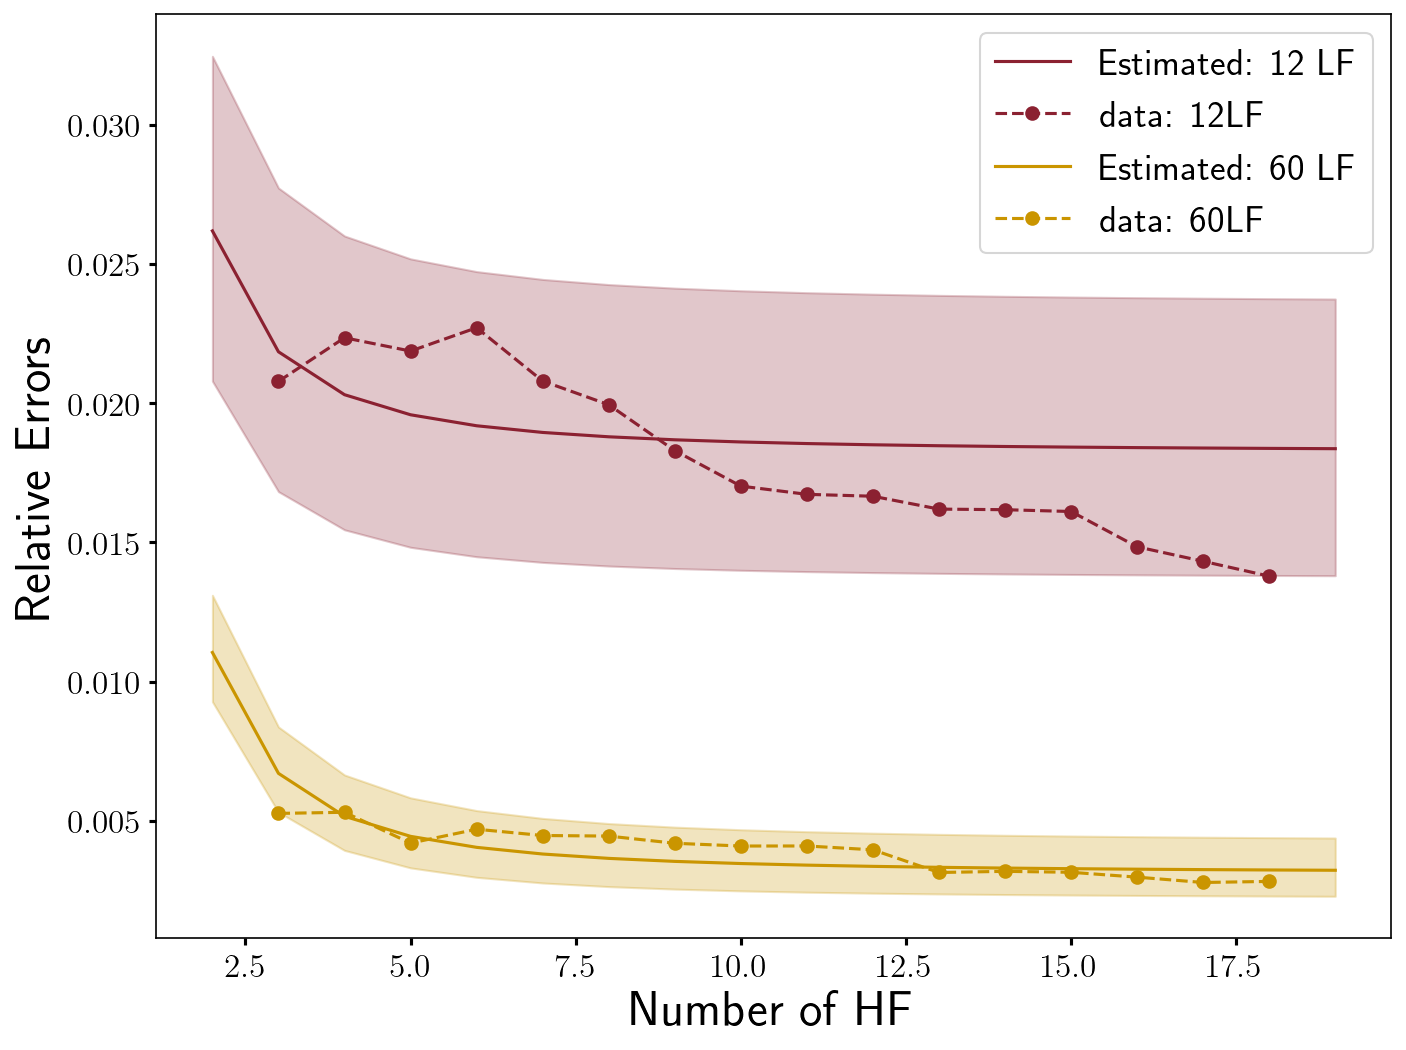

In [19]:
fig, ax = plt.subplots(figsize=(10.625, 8), nrows=1, ncols=1)


plot_hf_fn(
    hf_min=2,
    hf_max=20,
    selected_lf=12,
    rho1_median=rho1_median,
    rho2_median=rho2_median,
    theta_median=theta_median,
    nu1_median=nu1_median,
    nu2_median=nu2_median,
    nu0_median=nu0_median,
    rho1_upper=rho1_upper,
    rho2_upper=rho2_upper,
    theta_upper=theta_upper,
    nu1_upper=nu1_upper,
    nu2_upper=nu2_upper,
    nu0_upper=nu0_upper,
    rho1_lower=rho1_lower,
    rho2_lower=rho2_lower,
    theta_lower=theta_lower,
    nu1_lower=nu1_lower,
    nu2_lower=nu2_lower,
    nu0_lower=nu0_lower,
    color=colors[0],
)



plot_hf_fn(
    hf_min=2,
    hf_max=20,
    selected_lf=60,
    rho1_median=rho1_median,
    rho2_median=rho2_median,
    theta_median=theta_median,
    nu1_median=nu1_median,
    nu2_median=nu2_median,
    nu0_median=nu0_median,
    rho1_upper=rho1_upper,
    rho2_upper=rho2_upper,
    theta_upper=theta_upper,
    nu1_upper=nu1_upper,
    nu2_upper=nu2_upper,
    nu0_upper=nu0_upper,
    rho1_lower=rho1_lower,
    rho2_lower=rho2_lower,
    theta_lower=theta_lower,
    nu1_lower=nu1_lower,
    nu2_lower=nu2_lower,
    nu0_lower=nu0_lower,
    color=colors[1],
)


plt.legend()

plt.xlabel("Number of HF")
plt.ylabel("Relative Errors")

plt.savefig("../../../Latex/mf_boxsize_paper/images/budget_inferred_HR_error_dgmgp.pdf", bbox_inches='tight', pad_inches=0.075)

In [78]:
import os

os.makedirs("../budget_size/mcmc_samples/", exist_ok=True)

trace.to_json("../budget_size/mcmc_samples/samples_dgmgp.json")

'../budget_size/mcmc_samples/samples_dgmgp.json'

## Budget Size estimation

In [102]:
n_estimated = lambda cost, rho, nu : (rho / cost) ** (5 / (5 + nu))

size_l1 = n_estimated(1, rho1_median, nu1_median)
size_l2 = n_estimated(1.7, rho2_median, nu2_median)
size_h  = n_estimated(140, 1, nu0_median)

(size_l1 / size_h, size_l2 / size_h)

(10.909210106752408, 8.47639469379756)

In [69]:
# Assuming L1 and L2 are combined, so cost combined
size_l1_joint_l2 = n_estimated(
    2.7,
    rho1_median + rho2_median,
    (nu1_median + nu2_median) / 2,
)

size_h = n_estimated(140, 1, nu0_median)

size_l1_joint_l2 / size_h

9.457963758885567

In [21]:
# This is upper bounds
size_l1 = n_estimated(1, rho1_upper, nu1_lower)
size_l2 = n_estimated(1.7, rho2_upper, nu2_lower)
size_h  = n_estimated(140, 1, nu0_lower)

(size_l1 / size_h, size_l2 / size_h)

(12.167745088178075, 9.423846642106673)

In [22]:
# This is lower bound
size_l1 = n_estimated(1, rho1_lower, nu1_upper)
size_l2 = n_estimated(1.7, rho2_lower, nu2_upper)
size_h  = n_estimated(140, 1, nu0_upper)

(size_l1 / size_h, size_l2 / size_h)

(9.705492742767172, 7.5737353938193435)

### All Emulator error plots (using predictions)

In [89]:
from scipy.interpolate import interp1d

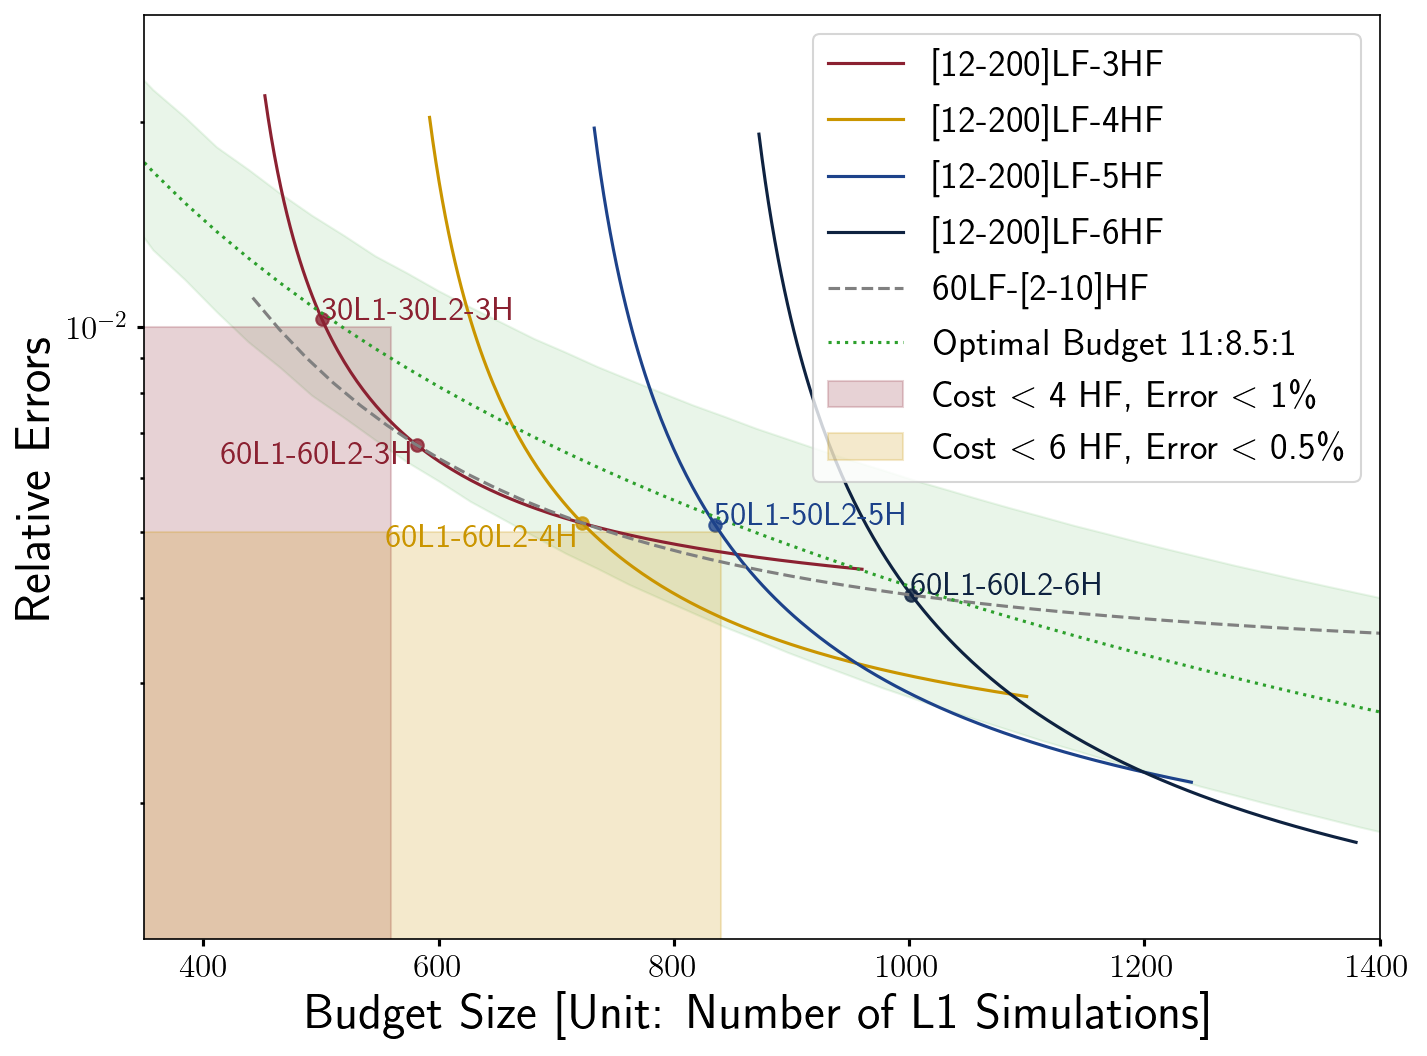

In [116]:
fig, ax = plt.subplots(figsize=(10.625, 8), nrows=1, ncols=1)

# The cost is combined with both L1 and L2
cost_hf = 140
cost_lf = (1 + 1.7)


# Make the lines instead of scattered points
all_selected_hfs = [3, 4, 5, 6,]
_nf_lf = np.arange(12, 201)

for i, _n_hf in enumerate(all_selected_hfs):

    _y_pred = budget_size_fn(_nf_lf, _n_hf, theta_median, rho1_median, rho2_median, nu1_median, nu2_median, nu0_median)

    ax.plot(
        _nf_lf * cost_lf + _n_hf * cost_hf, _y_pred,
        color=colors[i],
        label="[{}-{}]LF-{}HF".format(_nf_lf.min(), _nf_lf.max(), _n_hf),
    )

ax.set_yscale("log")

#################################################### Optimal ##########################################################
# Make a power law as a function of HF points
all_selected_lfs = [60]
_n_hf = np.linspace(2, 10)

for i, _n_lf in enumerate(all_selected_lfs):

    # Error(num of HFs)
    _y_pred_hf = budget_size_fn(_n_lf, _n_hf, theta_median, rho1_median, rho2_median, nu1_median, nu2_median, nu0_median)

    ax.plot(
        _n_lf * cost_lf + _n_hf * cost_hf, _y_pred_hf,
        color="grey",
        label="{}LF-[{}-{}]HF".format(_n_lf, int(_n_hf.min()), int(_n_hf.max())),
        ls="--",
    )
# Optimal line L1:L2:H = 11:8.5:1
_n_hf = np.linspace(2, 10)
l1_ratio = n_estimated(1,   rho1_median, nu1_median) / n_estimated(140, 1, nu0_median)
l2_ratio = n_estimated(1.7, rho2_median, nu2_median) / n_estimated(140, 1, nu0_median)
# Error(num of HFs)
_n_l1 = l1_ratio * _n_hf
_n_l2 = l2_ratio * _n_hf

_x = _n_l1 + _n_l2 * 1.7 + _n_hf * cost_hf

_y_pred_hf = budget_size_fn_l1_l2(
    _n_l1, _n_l2, _n_hf, theta_median, rho1_median, rho2_median, nu1_median, nu2_median, nu0_median
)
ax.plot(
    _x,
    _y_pred_hf,
    color="C2",
    label="Optimal Budget {:.2g}:{:.2g}:{:.2g}".format(l1_ratio, l2_ratio, 1),
    ls="dotted",
)
# Doesn't quite make sense. Plot uncertainty to see
_n_hf = np.linspace(0.1, 20) # expand the range for interpolation
# 1. Lower
l1_ratio = n_estimated(1,   rho1_upper, nu1_lower) / n_estimated(140, 1, nu0_lower)
l2_ratio = n_estimated(1.7, rho2_upper, nu2_lower) / n_estimated(140, 1, nu0_lower)
# Error(num of HFs)
_n_l1 = l1_ratio * _n_hf
_n_l2 = l2_ratio * _n_hf
_y_pred_lower = budget_size_fn_l1_l2(
    _n_l1, _n_l2, _n_hf, theta_lower, rho1_lower, rho2_lower, nu1_upper, nu2_upper, nu0_upper
)
# interpolation
_f_interp_lower = interp1d(
    _n_l1 + _n_l2 * 1.7 + _n_hf * cost_hf,
    _y_pred_lower,
    )

# 2. Upper
l1_ratio = n_estimated(1,   rho1_lower, nu1_upper) / n_estimated(140, 1, nu0_upper)
l2_ratio = n_estimated(1.7, rho2_lower, nu2_upper) / n_estimated(140, 1, nu0_upper)
# Error(num of HFs)
_n_l1 = l1_ratio * _n_hf
_n_l2 = l2_ratio * _n_hf
_y_pred_upper = budget_size_fn_l1_l2(
    _n_l1, _n_l2, _n_hf, theta_upper, rho1_upper, rho2_upper, nu1_lower, nu2_lower, nu0_lower
)
# interpolation
_f_interp_upper = interp1d(
    _n_l1 + _n_l2 * 1.7 + _n_hf * cost_hf,
    _y_pred_upper,
    )

ax.fill_between(
    _x,
    _f_interp_lower(_x),
    _f_interp_upper(_x),
    color="C2",
    alpha=0.1,
)

##############################################################################################################

# Plot the points I want
_selected_points = [
    (30, 3),
    # (40, 4),
    (60, 4),
    (50, 5),
    (60, 6),
]
for i, (_i_lf, _i_hf) in enumerate(_selected_points):
    _y_i_pred = budget_size_fn(_i_lf, _i_hf, theta_median, rho1_median, rho2_median, nu1_median, nu2_median, nu0_median)

    ax.scatter(_i_lf * cost_lf + _i_hf * cost_hf, _y_i_pred, color=colors[i], alpha=0.8)

    if i == 1:
        # Well, not a clean solution
        ax.text(
            _i_lf * cost_lf + _i_hf * cost_hf - cost_hf - cost_lf * 10,
            _y_i_pred                         - 4e-4,
            "{}L1-{}L2-{}H".format(_i_lf, _i_lf, _i_hf),
            color=colors[i],
        )
    else:
        ax.text(
            _i_lf * cost_lf + _i_hf * cost_hf,
            _y_i_pred,
            "{}L1-{}L2-{}H".format(_i_lf, _i_lf, _i_hf),
            color=colors[i],
        )

    # addition point
    if i == 0:
        # 60-3
        _i_lf, _i_hf = 60, 3
        _y_i_pred = budget_size_fn(_i_lf, _i_hf, theta_median, rho1_median, rho2_median, nu1_median, nu2_median, nu0_median)
        ax.scatter(_i_lf * cost_lf + _i_hf * cost_hf, _y_i_pred, color=colors[i], alpha=0.8)
        # Well, not a clean solution
        ax.text(
            _i_lf * cost_lf + _i_hf * cost_hf - cost_hf - cost_lf * 10,
            _y_i_pred                         - 4e-4,
            "{}L1-{}L2-{}H".format(_i_lf, _i_lf, _i_hf),
            color=colors[i],
        )



# Regime with < 1% error and low cost
ax.fill_between(
    np.linspace(0, 4 * cost_hf), y1=0.01, alpha=0.2, color=colors[0],
    label="Cost $<$ 4 HF, Error $<$ 1\%"
)
ax.fill_between(
    np.linspace(0, 6 * cost_hf), y1=0.005, alpha=0.2, color=colors[1],
    label="Cost $<$ 6 HF, Error $<$ 0.5\%"
)


# Label some selected emulators
# for i,(x,y) in enumerate(zip(n_lf + n_hf * cost, y_true)):
#     # if i < 40:
#     #     plt.text(x, y, i)    
#     if i in [0, 3, 8, 26]:
#         plt.text(x, y, "{}LF+{}HF".format(int(n_lf[i]), int(n_hf[i])))

ax.set_xlim(350, 1400)
ax.legend()

plt.xlabel("Budget Size [Unit: Number of L1 Simulations]")
plt.ylabel("Relative Errors")

fig.savefig("../../../Latex/mf_boxsize_paper/images/budget_all_predicted_costs_dgmgp.pdf", bbox_inches='tight', pad_inches=0.075)

Sort of curious about what it looks like in a long run

Text(0, 0.5, 'Relative Errors')

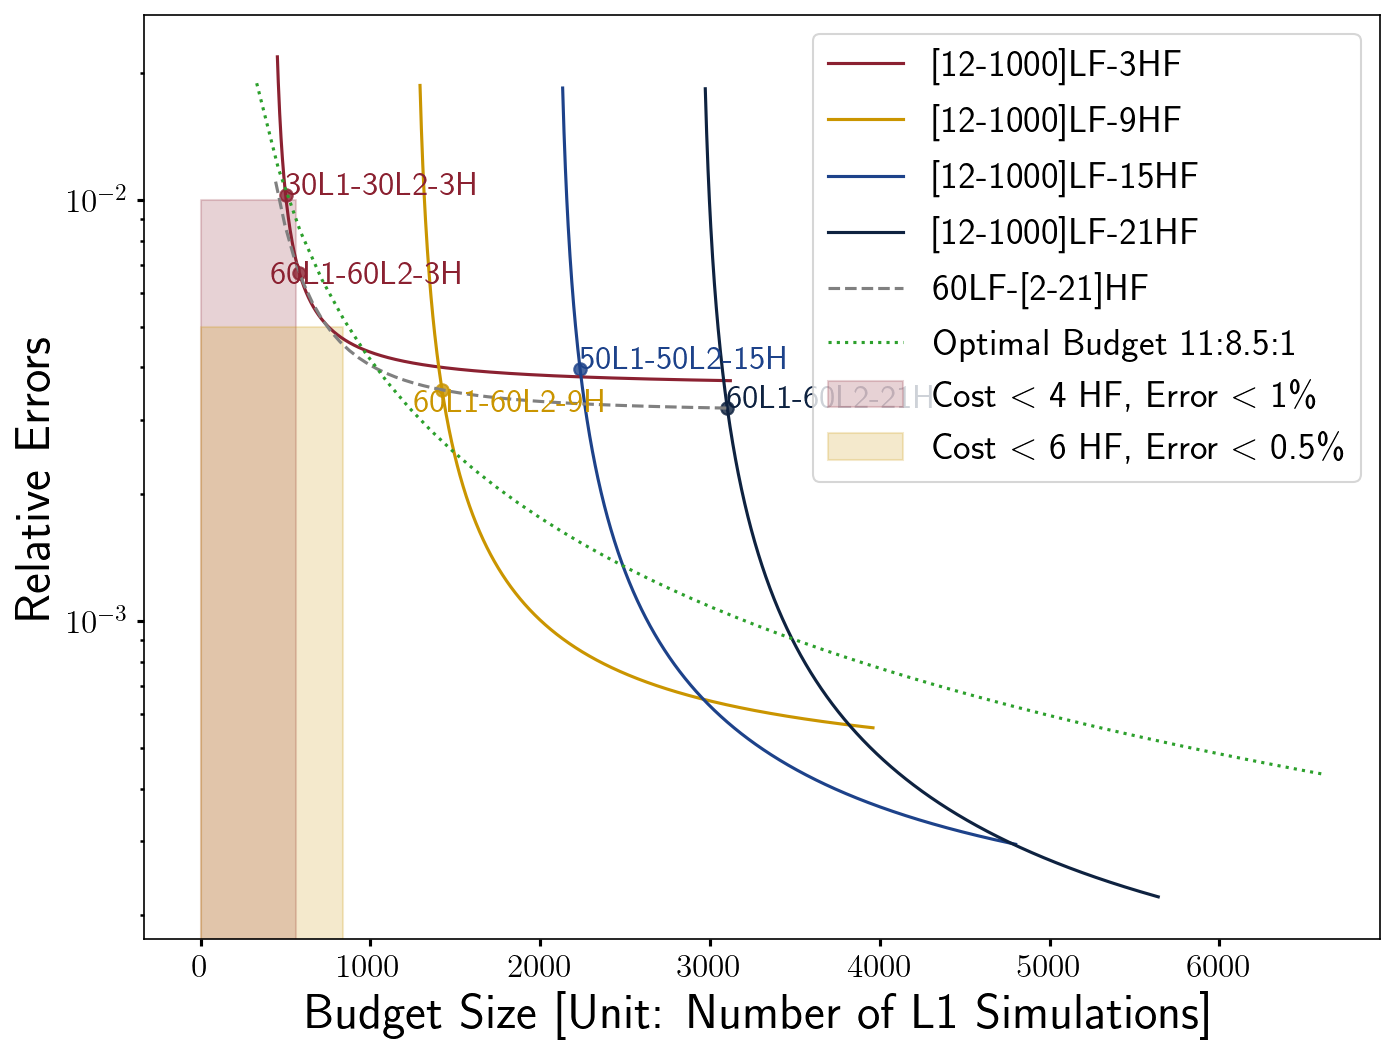

In [112]:
fig, ax = plt.subplots(figsize=(10.625, 8), nrows=1, ncols=1)

# The cost is combined with both L1 and L2
cost_hf = 140
cost_lf = (1 + 1.7)

# Make the lines instead of scattered points
all_selected_hfs = [3, 9, 15, 21,]
_nf_lf = np.arange(12, 1001)

for i, _n_hf in enumerate(all_selected_hfs):

    _y_pred = budget_size_fn(_nf_lf, _n_hf, theta_median, rho1_median, rho2_median, nu1_median, nu2_median, nu0_median)

    ax.plot(
        _nf_lf * cost_lf + _n_hf * cost_hf, _y_pred,
        color=colors[i],
        label="[{}-{}]LF-{}HF".format(_nf_lf.min(), _nf_lf.max(), _n_hf),
    )

#################################################### Optimal ##########################################################
# Make a power law as a function of HF points
all_selected_lfs = [60]
_n_hf = np.linspace(2, 21)

for i, _n_lf in enumerate(all_selected_lfs):

    # Error(num of HFs)
    _y_pred_hf = budget_size_fn(_n_lf, _n_hf, theta_median, rho1_median, rho2_median, nu1_median, nu2_median, nu0_median)

    ax.plot(
        _n_lf * cost_lf + _n_hf * cost_hf, _y_pred_hf,
        color="grey",
        label="{}LF-[{}-{}]HF".format(_n_lf, int(_n_hf.min()), int(_n_hf.max())),
        ls="--",
    )
# Optimal line L1:L2:H = 11:8.5:1
_n_hf = np.linspace(2, 40)
l1_ratio = n_estimated(1,   rho1_median, nu1_median) / n_estimated(140, 1, nu0_median)
l2_ratio = n_estimated(1.7, rho2_median, nu2_median) / n_estimated(140, 1, nu0_median)
# Error(num of HFs)
_n_l1 = l1_ratio * _n_hf
_n_l2 = l2_ratio * _n_hf

_x = _n_l1 + _n_l2 * 1.7 + _n_hf * cost_hf

_y_pred_hf = budget_size_fn_l1_l2(
    _n_l1, _n_l2, _n_hf, theta_median, rho1_median, rho2_median, nu1_median, nu2_median, nu0_median
)
ax.plot(
    _x,
    _y_pred_hf,
    color="C2",
    label="Optimal Budget {:.2g}:{:.2g}:{:.2g}".format(l1_ratio, l2_ratio, 1),
    ls="dotted",
)


##############################################################################################################

# Plot the points I want
_selected_points = [
    (30, 3),
    # (40, 4),
    (60, 9),
    (50, 15),
    (60, 21),
]
for i, (_i_lf, _i_hf) in enumerate(_selected_points):
    _y_i_pred = budget_size_fn(_i_lf, _i_hf, theta_median, rho1_median, rho2_median, nu1_median, nu2_median, nu0_median)

    ax.scatter(_i_lf * cost_lf + _i_hf * cost_hf, _y_i_pred, color=colors[i], alpha=0.8)

    if i == 1:
        # Well, not a clean solution
        ax.text(
            _i_lf * cost_lf + _i_hf * cost_hf - cost_hf - cost_lf * 10,
            _y_i_pred                         - 4e-4,
            "{}L1-{}L2-{}H".format(_i_lf, _i_lf, _i_hf),
            color=colors[i],
        )
    else:
        ax.text(
            _i_lf * cost_lf + _i_hf * cost_hf,
            _y_i_pred,
            "{}L1-{}L2-{}H".format(_i_lf, _i_lf, _i_hf),
            color=colors[i],
        )

    # addition point
    if i == 0:
        # 60-3
        _i_lf, _i_hf = 60, 3
        _y_i_pred = budget_size_fn(_i_lf, _i_hf, theta_median, rho1_median, rho2_median, nu1_median, nu2_median, nu0_median)
        ax.scatter(_i_lf * cost_lf + _i_hf * cost_hf, _y_i_pred, color=colors[i], alpha=0.8)
        # Well, not a clean solution
        ax.text(
            _i_lf * cost_lf + _i_hf * cost_hf - cost_hf - cost_lf * 10,
            _y_i_pred                         - 4e-4,
            "{}L1-{}L2-{}H".format(_i_lf, _i_lf, _i_hf),
            color=colors[i],
        )



# Regime with < 1% error and low cost
ax.fill_between(
    np.linspace(0, 4 * cost_hf), y1=0.01, alpha=0.2, color=colors[0],
    label="Cost $<$ 4 HF, Error $<$ 1\%"
)
ax.fill_between(
    np.linspace(0, 6 * cost_hf), y1=0.005, alpha=0.2, color=colors[1],
    label="Cost $<$ 6 HF, Error $<$ 0.5\%"
)

# ax.set_xlim(350, 1400)
ax.legend()

# ax.set_xscale("log")
ax.set_yscale("log")

plt.xlabel("Budget Size [Unit: Number of L1 Simulations]")
plt.ylabel("Relative Errors")

# fig.savefig("../../../Latex/mf_boxsize_paper/images/budget_all_predicted_costs_dgmgp.pdf", bbox_inches='tight', pad_inches=0.075)

## How good you can infer this multi-fidelity power-law relation by using low-fidelity only??

What you can do:
1. Take LF SLHD training set, k-fold splitting and test on some of them (maybe 9 of them a batch).
2. Once you have the errors, do the inference again.
3. Try different boxsizes, and supposedly boxsize smaller the correlation higher (?)

In [27]:
os.chdir("/Users/jibanmac/Documents/GitHub/matter_emu_dgmgp/")